In [1]:
from __future__ import print_function
import numpy as np
from kadi import events
from Ska.engarchive import fetch_eng as fetch
from Chandra.Time import DateTime
import matplotlib.pyplot as plt
from Ska.Matplotlib import plot_cxctime
from astropy.table import Table
from Quaternion import Quat
from itertools import cycle
import astropy.units as u

### Star centroids, obsid just before the bad maneuver ###

In [2]:
fetch.data_source.set('maude')

In [3]:
start = '2017:090:17:00:00'
stop = '2017:090:18:27:00'

#if 'dat' not in globals():
dat = fetch.MSIDset(['aoacyan*', 'aoaczan*', 'aoacmag*'], start, stop)

In [4]:
# Magn of the hot pixels in slots 6 and 7
t_2hp = '2017:090:18:16:49'
ok = (np.abs(dat['aoacmag6'].times - DateTime(t_2hp).secs)).argmin()

for i in [3, 4, 5, 6, 7]:
    print(dat['aoacmag{}'.format(i)].vals[ok])

7.1875
9.75
8.1875
10.625
10.625


In [5]:
t1 = '2017:090:17:13:00'
t2 = '2017:090:17:17:00'
t3 = '2017:090:17:33:00'
t4 = '2017:090:18:02:00'
t5 = '2017:090:18:05:50'
t6 = '2017:090:18:10:50'
t7 = '2017:090:18:24:00'
t8 = stop

times = [t1, t2, t3, t4, t5, t6, t7, t8]

In [6]:
idxs = []
for time in times:
    idx = (np.abs(dat['aoacmag0'].times - DateTime(time).secs)).argmin()
    idxs.append(idx)

Gray vertical lines: times t1-t6
Yellow vertical line: time t_2hp, to estimate the mag of the two hot pixels


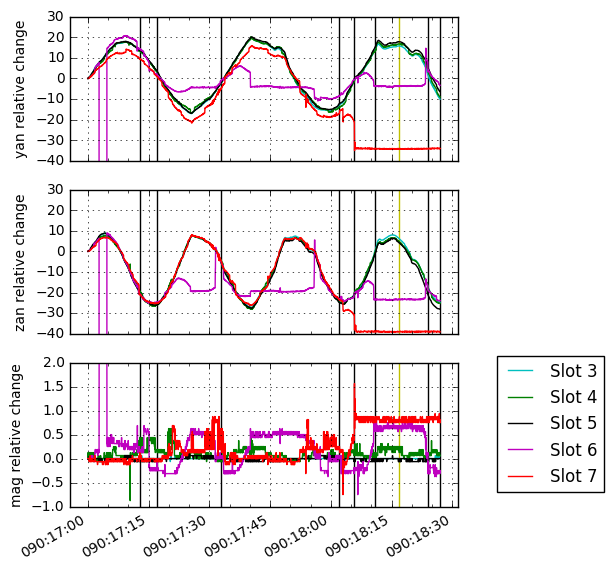

In [7]:
print("Gray vertical lines: times t1-t6")
print("Yellow vertical line: time t_2hp, to estimate the mag of the two hot pixels")

plt.close(1)
plt.figure(figsize=(5, 7))

ylims = [(-40, 30), (-40, 30), (-1, 2)]

for idx, coord in enumerate(['yan', 'zan', 'mag']):
    plt.subplot(3, 1, idx + 1)
    for slot, color in zip(np.arange(3, 8), 'cgkmr'):
        msid = dat['aoac{}{}'.format(coord, slot)]
        plot_cxctime(msid.times, msid.vals - msid.vals[0], color,
                     label='Slot {}'.format(slot))
    plt.ylim(ylims[idx])
    plt.ylabel("{} relative change".format(coord))
    plt.grid()
    plt.vlines(DateTime(times).plotdate, -40, 30, 'k')
    plt.vlines(DateTime([t_2hp]).plotdate, -40, 30, 'y')
    plt.margins(0.05)

plt.legend(loc=(1.1, 0.1))

plt.show()

### ACA image snapshots between 17:56:05 and 18:23:34 ###

<img style="float: left" src='17_56_05.png' width='670'> Just after star image<br>
is recovered in slot 6<br>
<img style="float: left" src='18_02_31.png' width='670'><br><br><br><br><br><br>
<img style="float: left" src='18_03_02.png' width='670'><br>Hot pixel takes over<br>
slot 7, another hot pixel<br> starts disturbing slot 6<br>
<img style="float: left" src='18_03_03.png' width='670'><br><br><br><br>
<img style="float: left" src='18_03_08.png' width='670'><br><br><br><br>
<img style="float: left" src='18_05_59.png' width='670'><br><br><br><br>
<img style="float: left" src='18_10_38.png' width='670'><br><br><br>Hot pixels tracked<br>
in slots 6 and 7<br><br>
<img style="float: left" src='18_23_34.png' width='670'><br>Star image recovered<br>
in slot 6<br>

### Change in ground att. estimate ###

In [8]:
asol_file = 'pcadf607366811N001_asol1.fits.gz'
grnd_sol = Table.read(asol_file)

In [9]:
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(grnd_sol['time'], drs, '-b', label='Roll')
    plot_cxctime(grnd_sol['time'], dps, '-g', label='Pitch')
    plot_cxctime(grnd_sol['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{}'.format(label))
    plt.ylabel('Change (arcsec)')
    plt.xlabel('Time')
    #plt.legend(loc='best');

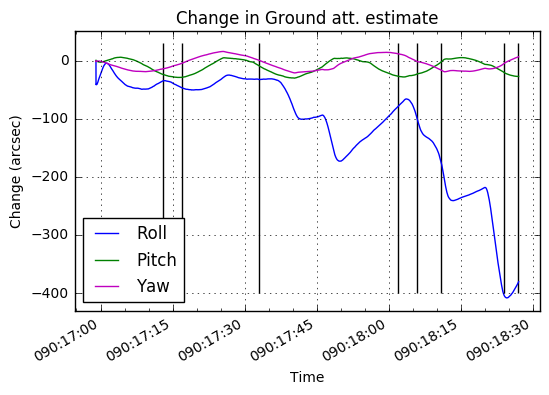

In [10]:
label = 'Change in Ground att. estimate'
plot_att_changes(refs=grnd_sol[:1], atts=grnd_sol, label=label)
plt.legend(loc='best')
plt.vlines(DateTime(times).plotdate, -400, 30, 'k')
plt.show()

In [11]:
#OBSID: 18983  IGR J16120-3543        ACIS-I SIM Z offset:0     (0.00mm) Grating: NONE 
#RA, Dec, Roll (deg):   242.979061   -35.773101    69.916905
#Dither: ON  Y_amp=16.0  Z_amp=16.0  Y_period=2000.0  Z_period=1414.8
#
#MP_TARGQUAT at 2017:090:16:35:48.735 (VCDU count = 14952866)
#  Q1,Q2,Q3,Q4: 0.49947489  -0.33350427  -0.75701845  0.25733791

Q1, Q2, Q3, Q4 = [0.49947489, -0.33350427, -0.75701845, 0.25733791]
q_planned = Quat([Q1, Q2, Q3, Q4])

start = '2017:090:17:00:00'
stop = '2017:090:18:27:00'
dat = fetch.MSIDset(['aoattqt*'], start, stop)

__ Compare with obc att. estimate__

In [12]:
rows = []
for ii, idx in enumerate(idxs):
    q1 = dat['aoattqt1'].vals[idx]
    q2 = dat['aoattqt2'].vals[idx]
    q3 = dat['aoattqt3'].vals[idx]
    q4 = dat['aoattqt4'].vals[idx]
    quat = Quat([q1, q2, q3, q4])
    dq = quat.dq(q_planned)
    row = {'time': times[ii], 'droll0': dq.roll0 * 3600,
           'dpitch': dq.pitch * 3600, 'dyaw': dq.yaw * 3600}
    rows.append(row)
    
t = Table(rows)
cols = t.colnames
cols.remove('time')
for col in cols:
    t[col].format = '%.3f'
print(t['time', 'droll0', 'dpitch', 'dyaw'])

       time        droll0 dpitch   dyaw 
----------------- ------- ------ -------
2017:090:17:13:00   1.266 11.361  11.375
2017:090:17:17:00  -1.062 16.120   1.376
2017:090:17:33:00   0.249 -3.601  -3.053
2017:090:18:02:00   4.867 14.739 -13.991
2017:090:18:05:50 -28.734 12.783  -4.721
2017:090:18:10:50 -29.640 -3.849   8.251
2017:090:18:24:00  10.623  9.261   2.155
2017:090:18:27:00  24.872 15.982  -9.051


In [13]:
#import Ska.arc5gl
#arc5gl = Ska.arc5gl.Arc5gl()
#arc5gl.sendline('obsid=18983')
#arc5gl.sendline('version=last')
#arc5gl.sendline('get asp1{obcsol}')
#del arc5gl

### Gyro bias change ###

In [14]:
dat = fetch.MSIDset(['aogbias*'], start=grnd_sol['time'][0], stop=grnd_sol['time'][-1])

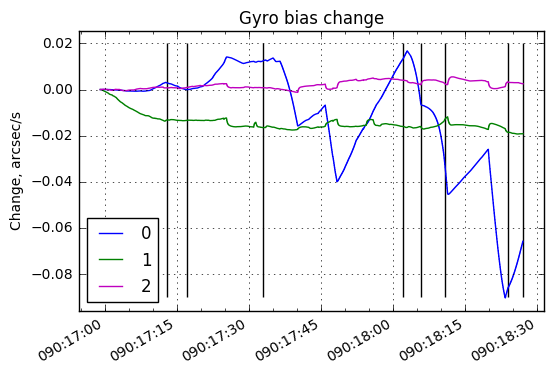

In [15]:
for i, color in zip(range(3), 'bgm'):
    msid = dat['aogbias{}'.format(i + 1)]
    plot_cxctime(msid.times,
                 ((msid.vals - msid.vals[0]) * u.radian / u.s).to('arcsec/s'),
                 color=color,
                 label='{}'.format(i))
plt.legend(loc='best')
plt.grid()
plt.margins(0.05)
plt.vlines(DateTime(times).plotdate, -0.09, 0.02, 'k')
plt.ylabel('Change, arcsec/s')
plt.title('Gyro bias change')
plt.show()

### Change in OBC estimated attitude relative to the final BSH attitude###

In [16]:
#dat = fetch.MSIDset(['aoacaseq'], start, stop)

<img src='bsh_2017_090_att.png'>

__ Important time stamps appear to be:__

In [17]:
t1 = '2017:090:18:55:40'
t2 = '2017:090:18:56:30'
t3 = '2017:090:18:58:35'
t4 = '2017:090:19:00:00'
t5 = '2017:090:19:02:00'
t6 = '2017:090:19:03:05'
t7 = '2017:090:19:07:00'

In [18]:
#dump2occ.py 2017_090_1147_090_2026_Dump_EM_54052N001.sto | splat.pl -vcdu 14952866

<img style="float: left" src='18_57_00.png' width='670'> GUID, between t2 and t3 <br>
Slot 2, star corrupted<br>
due to a hot pixel?<br>
<img style="float: left" src='18_57_56.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_17.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_26.png' width='670'> AQXN, between t3 and t4<br>
Slots 0-2 FIDs?<br>Slots 6-7 hot pixels<br>
<img style="float: left" src='18_58_30.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_42.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_51.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_54.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_57.png' width='670'><br><br><br><br><br>
<img style="float: left" src='19_00_02.png' width='670'>KALM, t4<br>
Slot 2, same star<br>
as between t2 and t3?<br><br>
<img style="float: left" src='19_02_10.png' width='670'>KALM -> BRIT, t5<br><br><br><br><br>
<img style="float: left" src='19_03_11.png' width='670'>BRIT -> KALM, t6<br>
Slot 6, corrupted<br>
due to a hot pixel,<br>
but not enough to cause<br>
significant att. errors
<img style="float: left" src='19_07_18.png' width='670'>
<img style="float: left" src='19_07_45.png' width='670'>
<img style="float: left" src='19_07_52.png' width='670'>
<img style="float: left" src='19_08_43.png' width='670'>

In [19]:
start = '2017:090:19:11:00'
stop = '2017:090:20:00:00'

dat_bsh = fetch.MSIDset(['aoacyan*', 'aoaczan*'], start, stop)

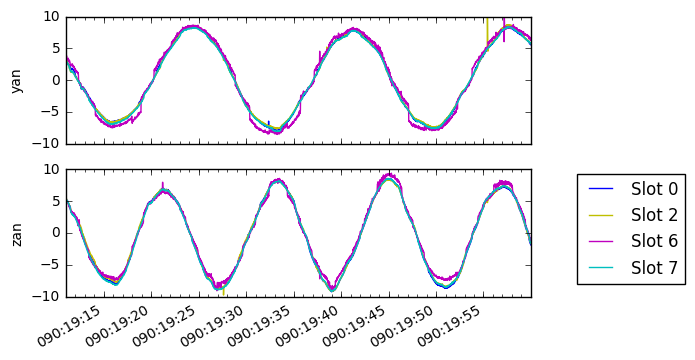

In [20]:
plt.close(1)
plt.figure(1)
plt.subplot(2, 1, 1)
for slot, color in zip([0, 2, 6, 7], 'bymc'):
    msid = dat_bsh['aoacyan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - np.median(msid.vals), color)
plt.ylim(-10, 10)
plt.ylabel("yan")

plt.subplot(2, 1, 2)
for slot, color in zip([0, 2, 6, 7], 'bymc'):
    msid = dat_bsh['aoaczan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - np.median(msid.vals), color,
                label='Slot {}'.format(slot))
plt.ylim(-10, 10)
plt.ylabel("zan")

plt.legend(loc=(1.1, 0.1))

plt.show()